<a href="https://colab.research.google.com/github/flashhyy/pneumonia-detection-inceptionv3/blob/main/ICMR_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

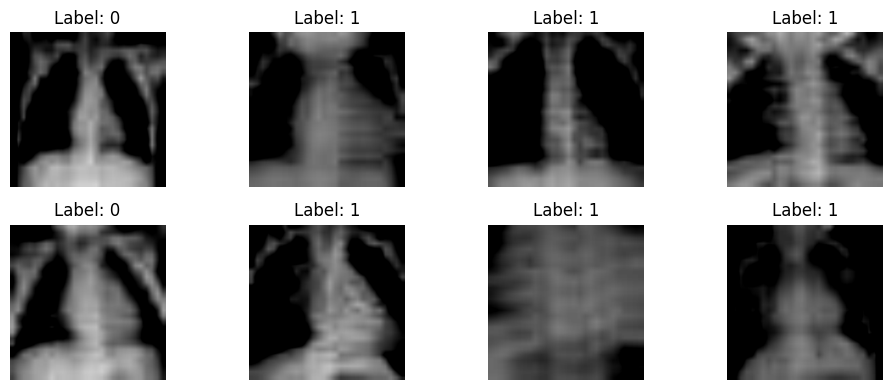

Label Distribution in Training Set: Counter({1: 3494, 0: 1214})
Class Weights: tensor([0.7421, 0.2579])
Epoch [1/2], Loss: 354.0587
Epoch [2/2], Loss: 284.5044


In [4]:
# Step 1: Install and Import Libraries
!pip install medmnist torchvision torch matplotlib --quiet

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, models
import matplotlib.pyplot as plt
from medmnist import INFO, PneumoniaMNIST
import numpy as np
from collections import Counter

# Step 2: Dataset Setup with 3-channel conversion for InceptionV3
data_flag = 'pneumoniamnist'
info = INFO[data_flag]
DataClass = getattr(__import__('medmnist'), info['python_class'])

# Correct Transform Sequence
data_transforms = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load training dataset
train_dataset = DataClass(split='train', transform=data_transforms, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=8, shuffle=True)

# Sample visualization
images, labels = next(iter(train_loader))
plt.figure(figsize=(10, 4))
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(images[i].permute(1, 2, 0))  # CxHxW to HxWxC for RGB
    plt.title(f"Label: {labels[i].item()}")
    plt.axis('off')
plt.tight_layout()
plt.show()

# Step 3: InceptionV3 Model Setup
model = models.inception_v3(weights=models.Inception_V3_Weights.DEFAULT)

# Freeze all base layers
for param in model.parameters():
    param.requires_grad = False

# Modify the final FC layer for binary classification (2 classes)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

# Set to training mode and move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.train()


# Count class samples from dataset
all_train_labels = [label.item() for _, label in train_dataset]
label_counts = Counter(all_train_labels)
print("Label Distribution in Training Set:", label_counts)

counts = torch.tensor([label_counts[0], label_counts[1]], dtype=torch.float32)
weights = 1.0 / counts
weights = weights / weights.sum()  # normalize to sum to 1

print("Class Weights:", weights)

criterion = nn.CrossEntropyLoss(weight=weights.to(device))

optimizer = optim.Adam(model.fc.parameters(), lr=1e-4)

# Training loop
num_epochs = 2
for epoch in range(num_epochs):
    running_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.squeeze().to(device).long()

        outputs = model(images)
        if isinstance(outputs, tuple):
            outputs = outputs[0]  # Extract main output

        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}")

In [5]:

!pip install scikit-learn --quiet
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from medmnist import PneumoniaMNIST

# Load test dataset
test_dataset = PneumoniaMNIST(split='test', transform=data_transforms, download=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=16, shuffle=False)

# Set model to eval mode
model.eval()

# Collect predictions and labels
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.squeeze().to(device).long()

        outputs = model(images)
        if isinstance(outputs, tuple):
            outputs = outputs[0]

        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate metrics
acc = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds)
rec = recall_score(all_labels, all_preds)
conf_mat = confusion_matrix(all_labels, all_preds)

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print("Confusion Matrix:")
print(conf_mat)


Accuracy: 0.7949
Precision: 0.7873
Recall: 0.9205
Confusion Matrix:
[[137  97]
 [ 31 359]]


In [6]:
from collections import Counter

# Re-check training labels
all_train_labels = [label.item() for _, label in train_dataset]

label_counts = Counter(all_train_labels)
print("Label Distribution in Training Set:", label_counts)


Label Distribution in Training Set: Counter({1: 3494, 0: 1214})
